In [10]:
import math
import sklearn
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt

In [11]:
# Define Network

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    s = np.maximum(0,x)
    return s

def forwardProp(X, parameters):

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

def backProp(X, Y, cache):

    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

In [12]:
def adamUpdating(parameters, grads, v, s, t, learning_rate = 0.0001, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
        
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving weighted average of the gradients : compute Vdb, Vdw
        v["dW" + str(l+1)] =  beta1*v["dW" + str(l+1)]+(1-beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] =  beta1*v["db" + str(l+1)]+(1-beta1)*grads['db' + str(l+1)]

        # Apply bias-correction on first moment estimate
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]//(1-(beta1)**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]//(1-(beta1)**t)

        # Moving weighted average of the squared gradients : compute Sdb, Sdw
        s["dW" + str(l+1)] =beta2*s["dW" + str(l+1)]+(1-beta2)*(grads['dW' + str(l+1)]**2)
        s["db" + str(l+1)] =beta2*s["db" + str(l+1)]+(1-beta2)*(grads['db' + str(l+1)]**2)
        
        # Apply bias-correction on second raw moment estimate
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1-(beta2)**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1-(beta2)**t)

        # Update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*(v_corrected["dW" + str(l+1)]/(s_corrected["dW" + str(l+1)]**0.5 + epsilon))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*(v_corrected["db" + str(l+1)]/(s_corrected["db" + str(l+1)]**0.5 + epsilon))

    return parameters, v, s

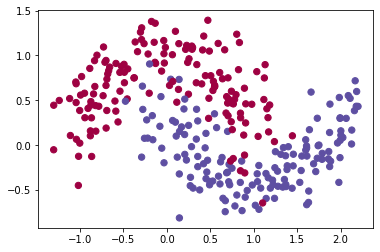

In [13]:
# Load a toy dataset

np.random.seed(3)
train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2)

# Visualize the data
plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
train_X = train_X.T
train_Y = train_Y.reshape((1, train_Y.shape[0]))

In [14]:
# Initialization for training

learning_rate = 0.0001
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8
num_epochs = 10000

layers_dims = [train_X.shape[0], 5, 2, 1]
L = len(layers_dims) # Number or layers
    
# Initialize parameters
np.random.seed(3)
parameters = {}
for l in range(1, L):
  parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*np.sqrt(2 / layers_dims[l-1])
  parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

costs = []                      
t = 0  # Counter for Adam update
seed = 10

# Initialize Adam optimizer    
v = {}
s = {}
L = len(parameters) // 2
for l in range(L):
  v["dW" + str(l+1)] = np.zeros(np.shape(parameters['W' + str(l+1)]))
  v["db" + str(l+1)] = np.zeros(np.shape(parameters['b' + str(l+1)]))
  s["dW" + str(l+1)] = np.zeros(np.shape(parameters['W' + str(l+1)]))
  s["db" + str(l+1)] = np.zeros(np.shape(parameters['b' + str(l+1)]))

In [15]:
# Train the model

# Optimization loop
for i in range(num_epochs):

  # Forward propagation
  a3, caches = forwardProp(train_X, parameters)

  # Compute cost
  cost = np.sum( np.multiply(-np.log(a3),train_Y) + np.multiply(-np.log(1 - a3), 1 - train_Y) )

  # Backward propagation
  grads = backProp(train_X, train_Y, caches)

  # Update parameters
  t = t + 1
  parameters, v, s = adamUpdating(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)

  if i % 1000 == 999:
    print ("Cost after epoch %i: %f" %(i+1, cost))
  if i % 100 == 0:
    costs.append(cost) 

Cost after epoch 1000: 93.506274
Cost after epoch 2000: 89.553555
Cost after epoch 3000: 89.466599
Cost after epoch 4000: 89.487449
Cost after epoch 5000: 89.902435
Cost after epoch 6000: 89.875437
Cost after epoch 7000: 89.851185
Cost after epoch 8000: 90.102553
Cost after epoch 9000: 89.895754
Cost after epoch 10000: 89.942330


In [16]:
# Predictions

m = train_X.shape[1]
preds = np.zeros((1,m), dtype = np.int64)
    
# Forward propagation
a3, caches = forwardProp(train_X, parameters)
    
# convert probas to 0/1 predictions
for i in range(0, a3.shape[1]):
  if a3[0,i] > 0.5:
    preds[0,i] = 1
  else:
    preds[0,i] = 0

In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(train_Y[0,:], preds[0,:] , normalize=False)
acc = 100*acc/len(preds[0,:])
print('Accuracy: %.2f' % acc)

Accuracy: 87.33


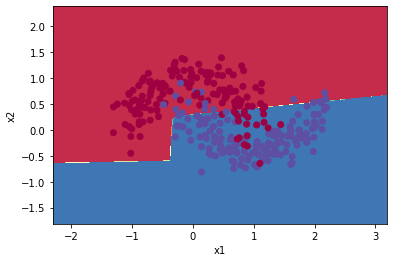

In [18]:
# Plot decision boundry

# Set min and max values and give it some padding
x_min, x_max = train_X[0, :].min() - 1, train_X[0, :].max() + 1
y_min, y_max = train_X[1, :].min() - 1, train_X[1, :].max() + 1

# Generate a grid of points with distance h between them
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict the function value for the whole grid
temp = (np.c_[xx.ravel(), yy.ravel()]).T
a3, cache = forwardProp(temp, parameters)
predictions = (a3 > 0.5)
Z = predictions.reshape(xx.shape)

# Plot
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y[0], cmap=plt.cm.Spectral)
plt.show()